# baseline

In [1]:
import json
import os
import time
import win32com.client
import pythoncom
import jsonlines
from pathlib import Path
from baseline import baseline1

def load_instructions(json_path):
    """instruction JSON 파일을 로드합니다."""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"JSON 파일 로드 오류: {e}")
        return {}

def get_slide_number(instruction_key):
    """instruction key에서 슬라이드 번호를 추출합니다."""
    if '-' in instruction_key:
        return instruction_key.split('-')[0]
    return instruction_key

def write_log(log_file, log_data):
    """로그 파일에 안전하게 데이터를 기록합니다."""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            with jsonlines.open(log_file, mode='a') as writer:
                writer.write(log_data)
            return True
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"로그 작성 오류, 재시도 중 ({attempt+1}/{max_retries}): {e}")
                time.sleep(0.5)
            else:
                print(f"로그 작성 최종 실패: {e}")
                return False

def get_processed_keys(log_file):
    """로그 파일에서 이미 처리된 instruction_key 목록을 가져옵니다."""
    processed_keys = set()
    if os.path.exists(log_file):
        try:
            with jsonlines.open(log_file, mode='r') as reader:
                for item in reader:
                    if 'instruction_key' in item:
                        processed_keys.add(item['instruction_key'])
        except Exception as e:
            print(f"로그 파일 읽기 오류: {e}")
    return processed_keys

def should_start_processing(key, target_key="4-4"):
    """
    target_key(4-4) 이후부터 처리할지 결정합니다.
    key가 target_key와 같거나 큰 경우 True를 반환합니다.
    """
    # 키가 숫자-숫자 형식이 아니면 항상 처리
    if not (all(k.isdigit() for k in key.split('-')) and '-' in key):
        return True
    
    if not (all(k.isdigit() for k in target_key.split('-')) and '-' in target_key):
        return True
    
    # 슬라이드 번호(첫 번째 숫자) 비교
    key_slide = int(key.split('-')[0])
    target_slide = int(target_key.split('-')[0])
    
    if key_slide > target_slide:
        return True
    elif key_slide < target_slide:
        return False
    
    # 슬라이드 번호가 같은 경우, 인스트럭션 번호(두 번째 숫자) 비교
    key_instr = int(key.split('-')[1])
    target_instr = int(target_key.split('-')[1])
    
    return key_instr >= target_instr

def process_instruction(instruction_key, instruction_text, result_folder, log_file):
    """
    주어진 instruction을 처리하고 결과를 저장합니다.
    1. PPT 열고 main() 적용
    2. SaveAs, 실패 시 SaveCopyAs → 원위치 이동
    3. 프레젠테이션 즉시 Close
    4. PowerPoint 애플리케이션 Quit
    5. 로그 기록
    """
    slide_num = get_slide_number(instruction_key)
    slide_path = os.path.abspath(f"evaluation/benchmark_ppts/slide_{slide_num}.pptx")
    result_path = os.path.join(result_folder, f"result_slide_{slide_num}_instruction_{instruction_key}.pptx")

    pythoncom.CoInitialize()
    ppt_app = None
    presentation = None
    start_time = time.time()
    status = "error"
    error_message = None
    result = None
    input_token = None
    output_token = None
    price = None
    response_code = None
    err = None

    try:
        # PowerPoint 연결 또는 실행
        try:
            ppt_app = win32com.client.GetActiveObject("PowerPoint.Application")
        except:
            ppt_app = win32com.client.Dispatch("PowerPoint.Application")
        if ppt_app is None:
            raise RuntimeError("PowerPoint 애플리케이션을 시작할 수 없습니다.")

        ppt_app.Visible = True
        
        # 프레젠테이션을 확실히 열고 준비되었는지 확인
        presentation = ppt_app.Presentations.Open(slide_path)
        if presentation is None:
            raise RuntimeError(f"프레젠테이션을 열 수 없습니다: {slide_path}")
        
        # PowerPoint가 완전히 로드될 시간을 제공
        time.sleep(0.5)
        
        # 인스트럭션 포맷팅
        if "{slide_num}" in instruction_text:
            formatted_instruction = instruction_text.replace("{slide_num}", "1")
        else:
            formatted_instruction = instruction_text
        
        # main 함수 실행 - PowerPoint가 확실히 준비된 후에 실행
        try:
            # 먼저 presentation이 active한지 확인
            ppt_app.ActivePresentation  # 이 호출로 PowerPoint가 활성화되어 있는지 확인
            # "gemini-2.5-flash-preview-04-17"
            result, input_token, output_token, price, response_code, err = baseline1(model_name="gpt-4.1-mini", user_instruction=formatted_instruction)
        except Exception as main_err:
            error_message = f"main() 함수 실행 오류: {main_err}"
            raise RuntimeError(error_message)

        # 디렉토리 및 파일 준비
        os.makedirs(os.path.dirname(result_path), exist_ok=True)
        if os.path.exists(result_path):
            try:
                os.remove(result_path)
            except:
                # 잠금 문제 시 이름 변경
                result_path = os.path.join(
                    result_folder,
                    f"result_slide_{slide_num}_instruction_{instruction_key}_{int(time.time())}.pptx"
                )

        absolute_result_path = os.path.abspath(result_path)
        save_success = False

        # 1차: SaveAs
        try:
            presentation.SaveAs(FileName=absolute_result_path)
            save_success = True
        except Exception as save_err:
            # 2차: SaveCopyAs + 이동
            try:
                temp_name = f"temp_{int(time.time())}_{os.path.basename(result_path)}"
                temp_path = os.path.join(os.path.dirname(absolute_result_path), temp_name)
                presentation.SaveCopyAs(FileName=temp_path)
                # 바로 프레젠테이션 닫기
                presentation.Close()
                presentation = None
                time.sleep(0.5)
                if os.path.exists(temp_path):
                    if os.path.exists(absolute_result_path):
                        os.remove(absolute_result_path)
                    os.rename(temp_path, absolute_result_path)
                    save_success = True
            except Exception as alt_err:
                error_message = f"SaveAs 실패: {save_err}; SaveCopyAs 실패: {alt_err}"

        # 저장 후 즉시 닫기
        if save_success:
            status = "success"
            # presentation이 남아있다면 닫기
            if presentation:
                presentation.Close()
                presentation = None

    except Exception as e:
        error_message = str(e)
        print(f"오류 발생: {instruction_key} – {e}")

    finally:
        # 애플리케이션 종료
        try:
            if ppt_app:
                ppt_app.Quit()
        except Exception as quit_err:
            print(f"PowerPoint Quit 오류: {quit_err}")

        # 로그 기록
        end_time = time.time()
        log_data = {
            "instruction_key": instruction_key,
            "slide_num": slide_num,
            "instruction": instruction_text,
            "execution_time": end_time - start_time,
            "status": status
        }
        if status == "success":
            log_data["result"] = result
            # 토큰 및 가격 정보 추가
            log_data["input_token"] = input_token
            log_data["output_token"] = output_token
            log_data["price"] = price
            log_data['response_code'] = str(response_code)
            log_data['code_error'] = str(err)
        if error_message:
            log_data["error_message"] = error_message
        write_log(log_file, log_data)

        try:
            pythoncom.CoUninitialize()
        except:
            pass

def main_experiment():
    total_start = time.time()
    instruction_path = "expanded_instruction_379.json"
    result_folder = "result_gpt4-1-mini-baseline"
    log_file = os.path.join(result_folder, "experiment_log.jsonl")
    os.makedirs(result_folder, exist_ok=True)

    # 시작 지점 설정 (4-4 이후부터)
    target_key = "4-4"
    #print(f"'{target_key}' 이후의 instruction_key부터 처리합니다.")
    
    # 이미 처리된 키 확인 (선택적)
    processed_keys = get_processed_keys(log_file)
    if processed_keys:
        print(f"이미 처리된 instruction_key 수: {len(processed_keys)}")
    
    instructions = load_instructions(instruction_path)
    if not instructions:
        print("인스트럭션 로드 실패, 종료합니다.")
        return

    # instruction_key를 정렬하여 순서대로 처리
    sorted_keys = sorted(instructions.keys(), key=lambda k: (
        int(k.split('-')[0]) if '-' in k and k.split('-')[0].isdigit() else float('inf'),
        int(k.split('-')[1]) if '-' in k and len(k.split('-')) > 1 and k.split('-')[1].isdigit() else float('inf')
    ))
    
    processed = 0
    skipped = 0
    for key in sorted_keys:
        # 이미 처리된 키는 건너뛰기 (선택적)
        if key in processed_keys:
            print(f"이미 처리됨, 건너뜀: {key}")
            skipped += 1
            continue
            
        # # target_key 이전의 키는 건너뛰기
        # if not should_start_processing(key, target_key):
        #     print(f"대상 키({target_key}) 이전이므로 건너뜀: {key}")
        #     skipped += 1
        #     continue
            
        text = instructions[key]
        if "{{slide_number}}" in text:
            text = text.replace("{{slide_number}}", "1")
            
        print(f"처리 중: {key}")
        process_instruction(key, text, result_folder, log_file)
        processed += 1
        time.sleep(1)

    total_end = time.time()
    summary = {
        "total_processed": processed,
        "total_skipped": skipped,
        "total_time": total_end - total_start,
        "avg_time": (total_end - total_start) / processed if processed else 0,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    write_log(log_file, summary)
    print("실험 완료:", summary)

if __name__ == "__main__":
    main_experiment()


c:\Users\wjdrb\anaconda3\envs\pptagent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


처리 중: 0-0
처리 중: 0-1
처리 중: 0-2
처리 중: 0-3
처리 중: 0-4
처리 중: 0-5
처리 중: 1-0
처리 중: 1-1
처리 중: 1-2
처리 중: 1-3
처리 중: 1-4
처리 중: 1-5
처리 중: 2-0
처리 중: 2-1
처리 중: 2-2
Error parsing runs: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2146827864), None)


Traceback (most recent call last):
  File "c:\Users\wjdrb\vscode_code\PPTAgent-4.16\pptagent\utils.py", line 354, in parse_text_frame_debug
    runs.append(make_run_dict(tr.Characters(cur_idx, seg_len)))
  File "<COMObject <unknown>>", line 2, in Characters
pywintypes.com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2146827864), None)


PowerPoint Quit 오류: PowerPoint.Application.Quit
처리 중: 2-3
처리 중: 2-4
처리 중: 2-5
처리 중: 2-6
처리 중: 3-0
처리 중: 3-1
처리 중: 3-2
처리 중: 3-3
처리 중: 3-4
처리 중: 3-5
처리 중: 3-6
처리 중: 3-7
처리 중: 4-0
처리 중: 4-1
처리 중: 4-2
처리 중: 4-3
처리 중: 4-4
처리 중: 4-5
처리 중: 5-0
처리 중: 5-1
처리 중: 5-2
처리 중: 5-3
처리 중: 5-4
처리 중: 5-5
처리 중: 6-0
처리 중: 6-1
처리 중: 6-2
처리 중: 6-3
처리 중: 6-4
처리 중: 6-5
처리 중: 7-0
처리 중: 7-1
처리 중: 7-2
처리 중: 7-3
처리 중: 7-4
처리 중: 7-5
처리 중: 7-6
처리 중: 7-7
처리 중: 8-0
처리 중: 8-1
처리 중: 8-2
처리 중: 8-3
처리 중: 8-4
처리 중: 8-5
처리 중: 9-0
처리 중: 9-1
처리 중: 9-2
처리 중: 9-3
처리 중: 9-4
처리 중: 9-5
처리 중: 9-6
처리 중: 10-0
처리 중: 10-1
처리 중: 10-2
처리 중: 10-3
처리 중: 10-4
처리 중: 10-5
처리 중: 11-0
처리 중: 11-1
처리 중: 11-2
처리 중: 11-3
처리 중: 11-4
처리 중: 11-5
처리 중: 12-0
처리 중: 12-1
처리 중: 12-2
처리 중: 12-3
처리 중: 12-4
처리 중: 12-5
처리 중: 13-0
처리 중: 13-1
처리 중: 13-2
처리 중: 13-3
처리 중: 13-4
처리 중: 13-5
처리 중: 14-0
처리 중: 14-1
처리 중: 14-2
처리 중: 14-3
처리 중: 14-4
처리 중: 15-0
처리 중: 15-1
처리 중: 15-2
처리 중: 15-3
처리 중: 15-4
처리 중: 16-0
처리 중: 16-1
처리 중: 16-2
처리 중: 16-3
처리 중: 16-4
처리 중: 16-5
처리

In [2]:
# 셀 1: 라이브러리 임포트
import json
import pandas as pd
import numpy as np
from IPython.display import display


In [4]:
# 셀 2: JSONL 파일 로드 함수 정의 및 데이터 프레임 생성
def load_jsonl(filepath):
    """JSONL 파일을 읽어 pandas.DataFrame 으로 반환"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# 실제 로드
df = load_jsonl("result_gpt4-1-mini-baseline/experiment_log.jsonl")
df.head()


,instruction_key,slide_num,instruction,execution_time,status,result,input_token,output_token,price,response_code,code_error,error_message
0,0-0,0,Convert all text on slide {slide_num} to English.,7.947293,success,False,467.0,318.0,0.000696,import win32com.client\n\ndef translate_text(t...,"Traceback (most recent call last):\n File ""c:...",NaN
1,0-1,0,Change the language of all visible text on sli...,7.126792,success,True,471.0,220.0,0.000540,import win32com.client\n\ndef change_slide_tex...,None,NaN
2,0-2,0,Translate every text element on slide {slide_n...,6.541251,success,True,468.0,292.0,0.000654,import win32com.client as win32\n\ndef transla...,None,NaN
3,0-3,0,Transform all visible text on slide {slide_num...,197.462930,success,True,470.0,281.0,0.000638,import win32com.client\n\ndef translate_slide_...,None,NaN
4,0-4,0,Modify the language of all text on slide {slid...,7.293251,success,True,470.0,223.0,0.000545,import win32com.client\n\ndef modify_slide_lan...,None,NaN


In [5]:
df['instruction_key']

0      0-0
1      0-1
2      0-2
3      0-3
4      0-4
      ... 
374     51
375     52
376     53
377     54
378     55
Name: instruction_key, Length: 379, dtype: object

{"total_processed": 22, "total_skipped": 357, "total_time": 724.9876101016998, "avg_time": 32.95398227734999, "timestamp": "2025-05-12 17:37:38"}


In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 카테고리 매핑 정의 (예시 코드에서 가져옴)
category_map = {
  "0": "TextEditing", "1": "TextEditing", "2": "TextEditing", 
  "3": "TextEditing", "4": "TextEditing", "5": "TextEditing",
  "6": "TextEditing", "7": "TextEditing", "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing", "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing", "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting", "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing", "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment", "32": "LayoutAndImageAdjustment",
  "33": "LayoutAndImageAdjustment", "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment", "38": "LayoutAndImageAdjustment",
  "39": "LayoutAndImageAdjustment", "40": "VisualFormatting", "41": "VisualFormatting",
  "42": "VisualFormatting", "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment", "50": "SlideStructure",
  "51": "SlideStructure", "52": "SlideStructure", "53": "VisualFormatting",
  "54": "TextEditing", "55": "TextEditing"
}

# JSONL 파일 로드 함수
def load_jsonl(filepath):
    """JSONL 파일을 읽어 pandas.DataFrame으로 반환"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            records.append(json.loads(line))
    return pd.DataFrame(records)

# instruction_key에서 카테고리 추출 함수
def get_category(key):
    # 하이픈이 있으면 첫 부분만 추출 (예: "2-2" -> "2")
    base_key = key.split('-')[0] if '-' in key else key
    return category_map.get(base_key, "Unknown")

# 파일 경로 설정
jsonl_filepath = "result_gpt4-1-mini-baseline/experiment_log.jsonl"  # 실제 파일 경로로 수정하세요

# 데이터 로드
df = load_jsonl(jsonl_filepath)


In [7]:

# 카테고리 컬럼 추가.
df['instruction_key'] = df['instruction_key'].fillna('').astype(str)

df['category'] = df['instruction_key'].apply(get_category)

# 실행 성공 여부 정의 (status가 success이고 result가 true인 경우)
df['execution_success'] = (df['status'] == 'success') & (df['result'] == True)

# 전체 실행 성공률 계산
overall_success_rate = df['execution_success'].mean() * 100
print(f"📊 전체 실행 성공률: {overall_success_rate:.2f}%")

# 성공한 실행만 필터링
success_df = df[df['execution_success']]


📊 전체 실행 성공률: 76.05%


In [8]:
success_df

,instruction_key,slide_num,instruction,execution_time,status,result,input_token,output_token,price,response_code,code_error,error_message,total_processed,total_skipped,total_time,avg_time,timestamp,category,execution_success
1,0-1,0,Change the language of all visible text on sli...,7.126792,success,True,471.0,220.0,0.000540,import win32com.client\n\ndef change_slide_tex...,None,NaN,NaN,NaN,NaN,NaN,NaN,TextEditing,True
2,0-2,0,Translate every text element on slide {slide_n...,6.541251,success,True,468.0,292.0,0.000654,import win32com.client as win32\n\ndef transla...,None,NaN,NaN,NaN,NaN,NaN,NaN,TextEditing,True
3,0-3,0,Transform all visible text on slide {slide_num...,197.462930,success,True,470.0,281.0,0.000638,import win32com.client\n\ndef translate_slide_...,None,NaN,NaN,NaN,NaN,NaN,NaN,TextEditing,True
4,0-4,0,Modify the language of all text on slide {slid...,7.293251,success,True,470.0,223.0,0.000545,import win32com.client\n\ndef modify_slide_lan...,None,NaN,NaN,NaN,NaN,NaN,NaN,TextEditing,True
5,0-5,0,Convert every text component on slide {slide_n...,8.098074,success,True,468.0,386.0,0.000805,import win32com.client\n\ndef translate_text_k...,None,NaN,NaN,NaN,NaN,NaN,NaN,TextEditing,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,51,51,Add slide numbers to every slide on the bottom...,17.687807,success,True,901.0,445.0,0.001072,import win32com.client\n\ndef add_slide_number...,None,NaN,NaN,NaN,NaN,NaN,NaN,SlideStructure,True
375,52,52,Re-order the slides so that they match the tab...,14.042342,success,True,1095.0,713.0,0.001579,import win32com.client\n\ndef reorder_slides_t...,None,NaN,NaN,NaN,NaN,NaN,NaN,SlideStructure,True
376,53,53,Add transition effects for all slides between ...,15.948289,success,True,1133.0,199.0,0.000772,import win32com.client\n\ndef add_transitions_...,None,NaN,NaN,NaN,NaN,NaN,NaN,VisualFormatting,True
377,54,54,Replace the presenter name in the presentation...,6.911102,success,True,1071.0,220.0,0.000780,import win32com.client\n\ndef replace_presente...,None,NaN,NaN,NaN,NaN,NaN,NaN,TextEditing,True


In [9]:

# 전체 성공 실행에 대한 통계 계산
print("\n📊 전체 성공 실행 통계")
print(f"총 데이터 수: {len(df)}")
print(f"성공 실행 수: {len(success_df)}")
print(f"평균 input tokens: {success_df['input_token'].mean():.2f}")
print(f"평균 output tokens: {success_df['output_token'].mean():.2f}")
print(f"평균 비용: ${success_df['price'].mean():.6f}")
print(f"평균 실행 시간: {success_df['execution_time'].mean():.2f}초")

# 카테고리별 통계 계산
print("\n📊 카테고리별 통계")

# 카테고리별 데이터 수 및 성공률
category_counts = df.groupby('category').size()
category_success_counts = success_df.groupby('category').size()
category_success_rates = (category_success_counts / category_counts) * 100

# 카테고리별 평균 통계 (성공한 실행에 대해서만)
category_stats = success_df.groupby('category').agg({
    'execution_time': 'mean',
    'input_token': 'mean',
    'output_token': 'mean',
    'price': 'mean'
}).rename(columns={
    'input_token': 'avg_input_tokens',
    'output_token': 'avg_output_tokens',
    'price': 'avg_cost',
    'execution_time': 'avg_execution_time'
})

# 성공률 추가
category_stats['success_rate'] = category_success_rates
category_stats['count'] = category_counts
category_stats['success_count'] = category_success_counts

# 파스텔 색상 설정 (시각화용)
pastel_colors = {
    'TextEditing': '#CCE5FF',
    'VisualFormatting': '#CCFFDD',
    'LayoutAndImageAdjustment': '#99CCFF',
    'SlideStructure': '#DDFFD6'
}

# 결과 출력
for category in sorted(category_stats.index):
    stats = category_stats.loc[category]
    print(f"\n🔹 {category}:")
    print(f"  총 데이터 수: {stats['count']}")
    print(f"  성공 실행 수: {stats['success_count']}")
    print(f"  성공률: {stats['success_rate']:.2f}%")
    print(f"  평균 input tokens: {stats['avg_input_tokens']:.2f}")
    print(f"  평균 output tokens: {stats['avg_output_tokens']:.2f}")
    print(f"  평균 비용: ${stats['avg_cost']:.6f}")
    print(f"  평균 실행 시간: {stats['avg_execution_time']:.2f}초")



📊 전체 성공 실행 통계
총 데이터 수: 380
성공 실행 수: 289
평균 input tokens: 1060.49
평균 output tokens: 481.70
평균 비용: $0.001195
평균 실행 시간: 18.19초

📊 카테고리별 통계

🔹 LayoutAndImageAdjustment:
  총 데이터 수: 95.0
  성공 실행 수: 66.0
  성공률: 69.47%
  평균 input tokens: 1044.80
  평균 output tokens: 525.18
  평균 비용: $0.001258
  평균 실행 시간: 17.06초

🔹 SlideStructure:
  총 데이터 수: 45.0
  성공 실행 수: 38.0
  성공률: 84.44%
  평균 input tokens: 910.47
  평균 output tokens: 654.66
  평균 비용: $0.001412
  평균 실행 시간: 19.57초

🔹 TextEditing:
  총 데이터 수: 116.0
  성공 실행 수: 89.0
  성공률: 76.72%
  평균 input tokens: 1033.92
  평균 output tokens: 408.28
  평균 비용: $0.001067
  평균 실행 시간: 18.55초

🔹 VisualFormatting:
  총 데이터 수: 123.0
  성공 실행 수: 96.0
  성공률: 78.05%
  평균 input tokens: 1155.30
  평균 output tokens: 451.40
  평균 비용: $0.001184
  평균 실행 시간: 18.08초


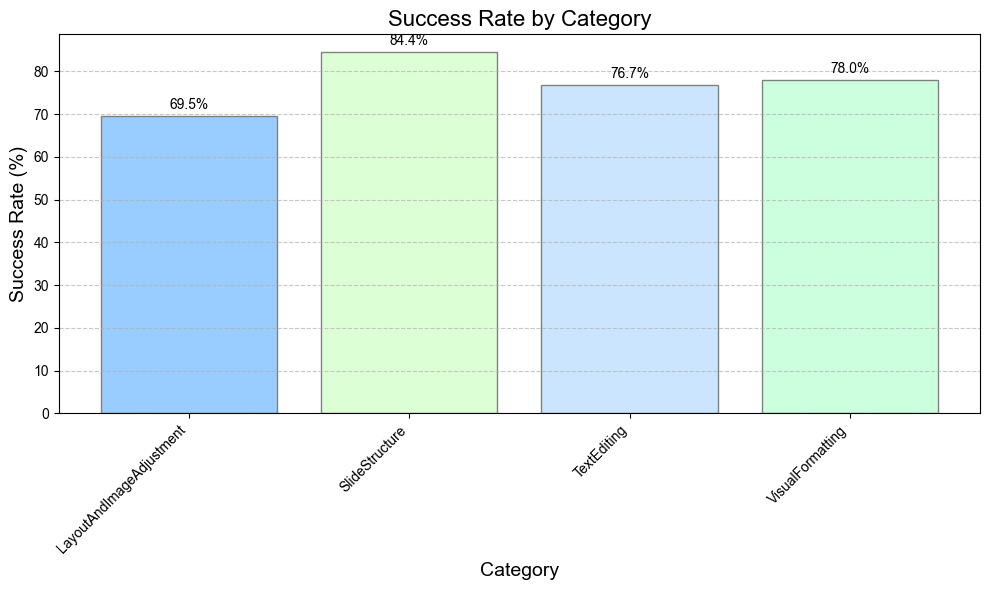

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36552\4208328509.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36552\4208328509.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36552\4208328509.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36552\4208328509.py:60: UserWarning: set_ticklabels() should only be used with a fixed

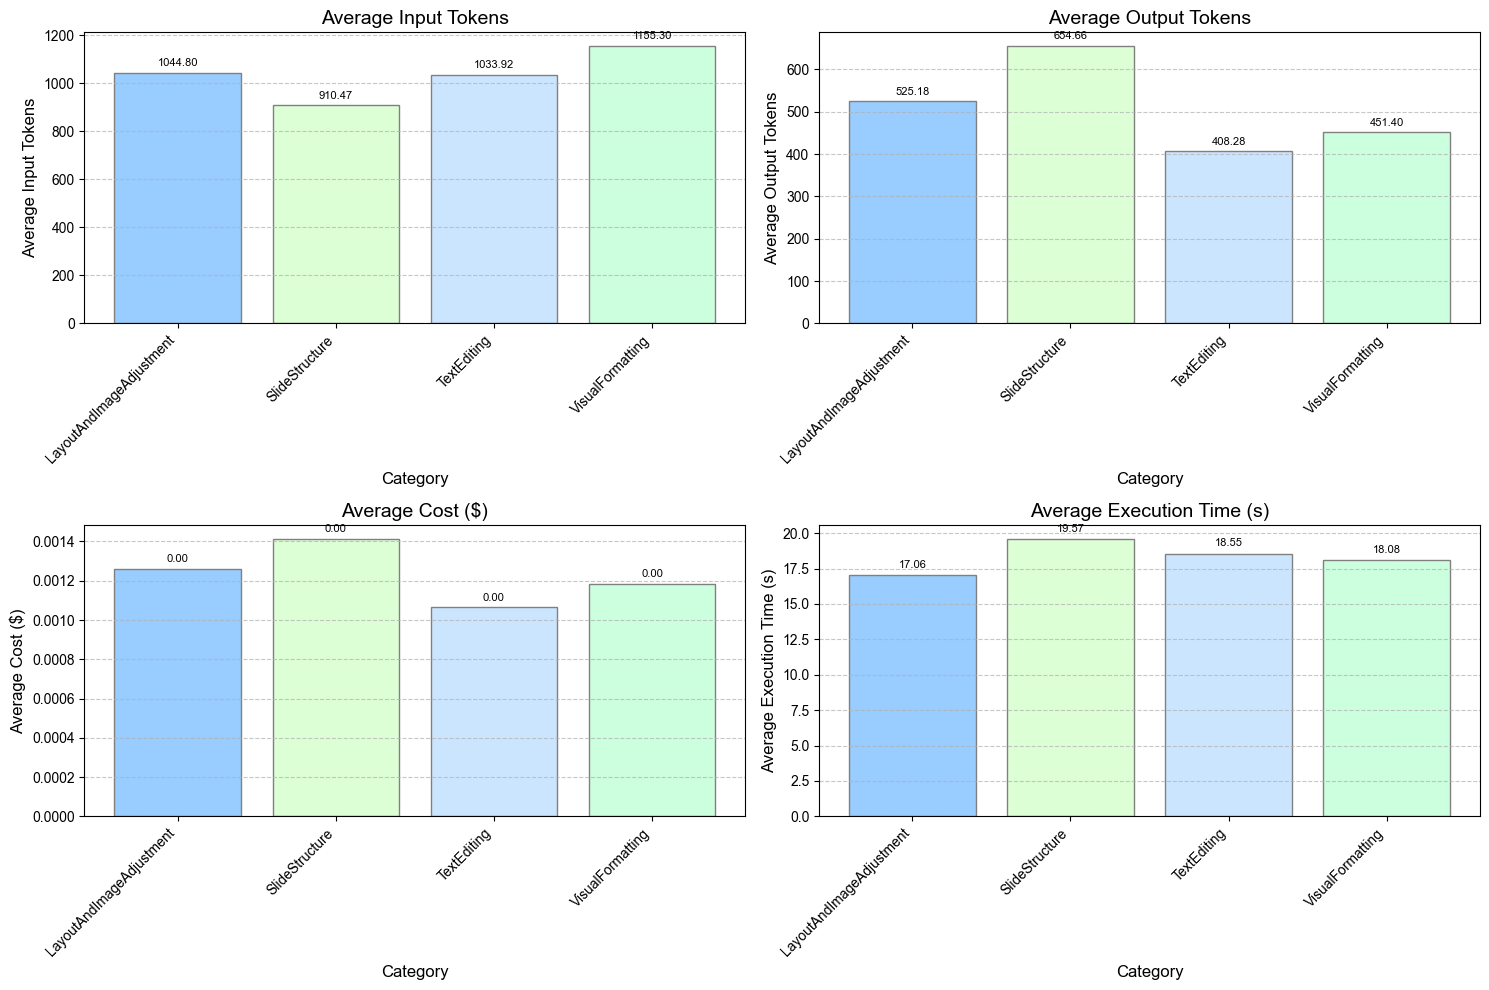


📊 Detailed category statistics have been saved to 'category_statistics.csv'.


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# -- Assume category_stats (a DataFrame) and pastel_colors (a dict) are already defined --

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

# 1. Success Rate by Category Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(
    category_stats.index,
    category_stats['success_rate'],
    color=[pastel_colors.get(cat, '#CCCCCC') for cat in category_stats.index],
    edgecolor='gray'
)
plt.title('Success Rate by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars with the success rate
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f'{height:.1f}%',
        ha='center', va='bottom',
        fontsize=10
    )

plt.savefig('category_success_rate.png')
plt.show()

# 2. Average Metrics by Category Visualization
metrics = ['avg_input_tokens', 'avg_output_tokens', 'avg_cost', 'avg_execution_time']
titles = {
    'avg_input_tokens': 'Average Input Tokens',
    'avg_output_tokens': 'Average Output Tokens',
    'avg_cost': 'Average Cost ($)',
    'avg_execution_time': 'Average Execution Time (s)'
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flat

for i, metric in enumerate(metrics):
    bars = axes[i].bar(
        category_stats.index,
        category_stats[metric],
        color=[pastel_colors.get(cat, '#CCCCCC') for cat in category_stats.index],
        edgecolor='gray'
    )
    axes[i].set_title(titles[metric], fontsize=14)
    axes[i].set_xlabel('Category', fontsize=12)
    axes[i].set_ylabel(titles[metric], fontsize=12)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate bars with the metric value
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width()/2,
            height * 1.02,
            f'{height:.2f}',
            ha='center', va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.savefig('category_metrics.png')
plt.show()

# 3. Detailed Statistics Table
detailed_df = pd.DataFrame({
    'Category': category_stats.index,
    'Total Samples': category_stats['count'],
    'Successful Runs': category_stats['success_count'],
    'Success Rate (%)': category_stats['success_rate'],
    'Average Execution Time (s)': category_stats['avg_execution_time'],
    'Average Input Tokens': category_stats['avg_input_tokens'],
    'Average Output Tokens': category_stats['avg_output_tokens'],
    'Average Cost ($)': category_stats['avg_cost']
})

# Save to CSV
detailed_df.to_csv('category_statistics.csv', index=False, encoding='utf-8-sig')
print("\n📊 Detailed category statistics have been saved to 'category_statistics.csv'.")
